In [299]:
import scipy.io
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from numpy import savez_compressed

from mpl_toolkits.axes_grid1 import make_axes_locatable

# %hist -o -g -f ipython_history.md

In [300]:
dwell_time = 5
file_path = f'Data/Processed/havsdata_{dwell_time}s.mat' # One may want to know how long might be neccessary to capture so that a high accuracy is achieved
saved_data_path = f'../Processed Data/processed_data_{dwell_time}s.npz'
saved_data_path_cv = '../Processed Data/processed_data_cv.npz'

In [301]:
# Read .mat file
processed_data = scipy.io.loadmat(file_path)

# Store data as numpy arrays
examples = np.array([example[0] for example in processed_data['processed_data_struct'][0]])
labels = np.array([example[1][0] for example in processed_data['processed_data_struct'][0]])
time_stamps = np.array([example[2][0][0][0] for example in processed_data['processed_data_struct'][0]])

def read_mat_files(file_path):
    # Store data as numpy arrays
    examples = np.array([example[0] for example in processed_data['processed_data_struct'][0]])
    labels = np.array([example[1][0] for example in processed_data['processed_data_struct'][0]])
    time_stamps = np.array([example[2][0][0][0] for example in processed_data['processed_data_struct'][0]])

    return examples, labels, time_stamps

KeyboardInterrupt: 

## Distribution of examples

<AxesSubplot:title={'center':'Recordings taken on 2020-09-08'}, xlabel='Time', ylabel='Number of Recordings'>

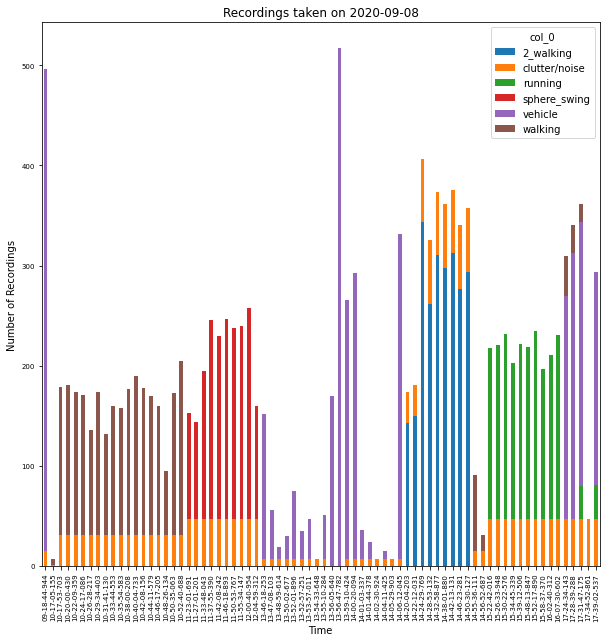

In [ ]:
# Display distribution of examples
time_stamps_without_date = np.array([time_stamp.split('_')[1] for time_stamp in time_stamps])
pd.crosstab(time_stamps_without_date, labels).plot(kind='bar', stacked=True, figsize=(10,10), 
                                                    fontsize=7, xlabel='Time', ylabel='Number of Recordings',
                                                    title='Recordings taken on 2020-09-08')


# Why is it like this above?

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

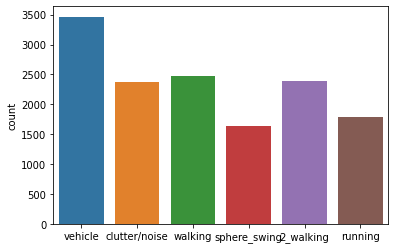

In [ ]:
sns.countplot(labels)

In [ ]:
# Get minimum and maximum value

max_value_dB = np.amax(examples)
min_value_dB = np.amin(examples)

print(max_value_dB)
print(min_value_dB)

141.54549664506658
-14.828100417399115


In [ ]:
# Group data by labels
walking_data = examples[np.where(labels == 'walking')]
vehicle_data = examples[np.where(labels == 'vehicle')]
clutter_data = examples[np.where(labels == 'clutter/noise')]
sphere_swing_data = examples[np.where(labels == 'sphere_swing')]
walking_2_data = examples[np.where(labels == '2_walking')]
running_data = examples[np.where(labels == 'running')]

# Get the average image
avg_clutter_image = sum(clutter_data)/len(clutter_data)
avg_vehicle_image = sum(vehicle_data)/len(vehicle_data)
avg_walking_image = sum(walking_data)/len(walking_data)
avg_sphere_swing_image = sum(sphere_swing_data)/len(sphere_swing_data)
avg_running_image = sum(running_data)/len(running_data)
avg_walking_2_image = sum(walking_2_data)/len(walking_2_data)

def get_label_data(examples, label):
    return examples[np.where(labels == label)]

## Average images

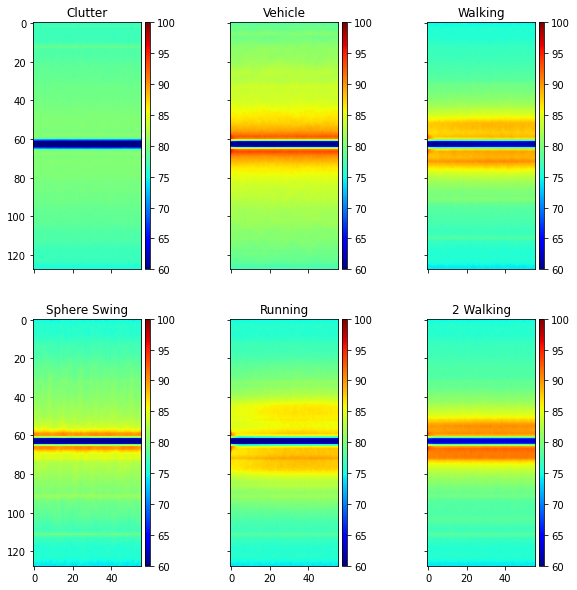

In [ ]:
n = 0
nrows = 2
ncols = 3

classes = ['Clutter', 'Vehicle', 'Walking', 'Sphere Swing', 'Running', '2 Walking']
images = [avg_clutter_image, avg_vehicle_image, avg_walking_image, avg_sphere_swing_image, avg_running_image, avg_walking_2_image]

fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 10))

# plt.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), ax=ax)

for row in range(nrows):
    for col in range(ncols):
        img = ax[row, col].imshow((images[n]), cmap='jet', vmin=60, vmax=100)
        ax[row, col].set_title(classes[n])

        divider = make_axes_locatable(ax[row, col])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(img, cax=cax, orientation='vertical')

        n += 1

## Analysis of results

Clutter/noise - low values as expected
Vehicle - returns from higher frequencies/speeds compared to returns from humams (expected as vehicles usually travel faster than humans)
Walking - returns from lower freqeuncies/speeds 
Sphere swing - returns are concentrated at lower freqs/speeds because the sphere will always slow down at the top or bottom of the circular path ???
Running - higher freqs/speeds compared to walking and 2 walking as expected
2 walking - higher returns compared to one person walking

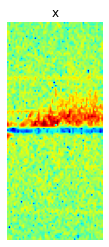

In [ ]:
plt.imshow(walking_2_data[0], cmap='jet')
plt.title('x')
plt.axis('off')
plt.show()

# Dividing the data

In [ ]:
# Convert time string to datetime object
datetime_times = np.array([datetime.datetime.strptime(time_stamp, '%H-%M-%S-%f').time() 
                            for time_stamp in time_stamps_without_date
                        ])

# Split 70/15/15 between train, validation and test data
split_ratio = 0.7

x_train, x_val, x_test, y_train, y_val, y_test  = [], [], [], [], [], []

# Walking examples after 13h00 were taken from a further distance
walking_data_after_13h00 = examples[np.where((labels == 'walking') & (datetime_times > datetime.time(13, 00, 00, 000)))]
walking_data_before_13h00 = examples[np.where((labels == 'walking') & (datetime_times < datetime.time(13, 00, 00, 000)))]

# Running examples after 17h28 were taken from a further distance
running_data_after_17h28 = examples[np.where((labels == 'running') & (datetime_times > datetime.time(17, 28, 00, 000)))]
running_data_before_17h28 = examples[np.where((labels == 'running') & (datetime_times < datetime.time(17, 28, 00, 000)))]

havs_data = [vehicle_data, 
            clutter_data, 
            sphere_swing_data, 
            walking_2_data, 
            walking_data_after_13h00, 
            walking_data_before_13h00,
            running_data_after_17h28, 
            running_data_before_17h28]

havs_labels = ['vehicle', 
            'clutter', 
            'sphere_swing', 
            'walking_2', 
            'walking', 
            'walking', 
            'running', 
            'running']

# Split the data
for i, data in enumerate(havs_data):
    train_stop_index = int(split_ratio * len(data))
    val_stop_index = int((split_ratio + (1 - split_ratio)/2)*len(data))

    for j in range(len(data)):
        if j <= train_stop_index:
            # Train set
            x_train.append(data[j])
            y_train.append(havs_labels[i])

        elif j <= val_stop_index:
            # Validation set
            x_val.append(data[j])
            y_val.append(havs_labels[i])

        else:
            # Test set
            x_test.append(data[j])
            y_test.append(havs_labels[i])

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

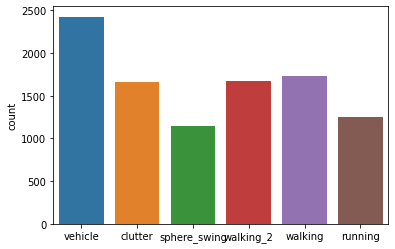

In [ ]:
# Distribution of examples
sns.countplot(y_train)

In [ ]:
# Sanity check

# New data
print(len(y_train) + len(y_val) + len(y_test))

# Old data
print(len(labels))


14119
14119


Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1. (https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/)

In [ ]:
# Convert to numpy array
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(9887, 128, 56)
(2118, 128, 56)
(2114, 128, 56)
(9887,)
(2118,)
(2114,)


# Saving data

In [ ]:
# save numpy array as npz file
savez_compressed(saved_data_path, x_train=x_train, x_test=x_test, x_val=x_val, y_train=y_train, y_test=y_test, y_val=y_val)

In [228]:
saved_data_path

'../Processed Data/processed_data_4s.npz'

In [64]:
#save to npy file cross validation data
x_train_cv = np.concatenate((x_train, x_val))
y_train_cv = np.concatenate((y_train, y_val))

savez_compressed(saved_data_path_cv, x_train=x_train_cv, x_test=x_test, y_train=y_train_cv, y_test=y_test)

In [303]:
x = random_4s_data = np.load('../Processed Data/processed_data_random_4s.npz')
x['x_train'].shape

(10002, 128, 45)

In [306]:
x['x_val'].shape

(2142, 128, 45)

In [80]:
random_4s_data = np.load('../Processed Data/processed_data_random_4s.npz')
random_data_x_val = random_4s_data['x_val']
random_data_y_val = random_4s_data['y_val']

standard_4s_data = np.load('../Processed Data/processed_data_4s.npz')
standard_data_x_val = standard_4s_data['x_val']
standard_data_y_val = standard_4s_data['y_val']

new_x_val_data = np.concatenate((random_data_x_val,standard_data_x_val))
new_y_val_data = np.concatenate((random_data_y_val,standard_data_y_val))

x_val=new_x_val_data
y_val=new_y_val_data

savez_compressed('../Processed Data/val_data.npz', x_train=x_train, x_test=x_test, x_val=x_val, y_train=y_train, y_test=y_test, y_val=y_val)


In [81]:
x_val.shape

(4832, 128, 45)